In [47]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy
from PIL import Image
import math
from skimage.metrics import structural_similarity as ssim
import neptune
from tqdm import tqdm
import uuid

%matplotlib inline

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [49]:
# adding neptuneai integration for the run

#create a random runid for neptuneai run
run_id = str(uuid.uuid4())

# initialize a new neptuneai run
run = neptune.init_run(
    project="ImgResProject/ImageRes",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NzgzODU4Zi03MWEyLTQwODktOWNiZS05MzJhNjc0MTAxODUifQ==",
    tags=["FSRCNN"],
    name="FSRCNN-6"
)

# add the runid to neptuneai id
run["id"] = run_id

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-18


In [50]:
# for loading dataset
class SuperResolutionDataset(Dataset):
    def __init__(self, low_res_image_dir, high_res_image_dir, csv_file=None, image_data=None, transform=None):
        if image_data is not None:
            self.image_data = image_data
        elif csv_file is not None:
            self.image_data = pd.read_csv(csv_file)
        self.transform = transform
        self.fixed_size = (800, 1200)
        self.csv_file = csv_file
        self.high_res_image_dir = high_res_image_dir
        self.low_res_image_dir = low_res_image_dir

        if len(self.image_data) == 0:
            raise ValueError(f"No image files found in CSV file: {csv_file}")
        
        print(f"Found {len(self.image_data)} image pairs.")

    def __len__(self):
        return len(self.image_data)
    
    def train_val_test_split(self, r1, r2, r3):
        assert r1 + r2 + r3 == 1, "Ratios must sum to 1"
        
        train_data, temp_data = train_test_split(self.image_data, test_size=(1 - r1))
        val_data, test_data = train_test_split(temp_data, test_size=(r3 / (r2 + r3)))
        
        train_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=train_data.reset_index(drop=True),
                                               transform=self.transform)
        
        val_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=val_data.reset_index(drop=True),
                                               transform=self.transform)
        
        test_dataset = SuperResolutionDataset(low_res_image_dir=self.low_res_image_dir,
                                               high_res_image_dir=self.high_res_image_dir,
                                               image_data=test_data.reset_index(drop=True),
                                               transform=self.transform)
        
        return train_dataset, val_dataset, test_dataset

    def __getitem__(self, index):
        # get image names in folders using index
        lr_image_path = self.image_data.iloc[index, 0]
        hr_image_path = self.image_data.iloc[index, 1]

        # add image path and convert it to RGB
        lr_img = Image.open(self.low_res_image_dir+lr_image_path).convert('RGB')
        hr_img = Image.open(self.high_res_image_dir+hr_image_path).convert('RGB')

        #apply transform for both images
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)

        return lr_img, hr_img

In [51]:
# define resize and transform - for FSRCNN we should not use any intrapolation on images
# define resize and transform
transform = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.ToTensor()
])

img_set_path = "image_dataset/Image Super Resolution - Unsplash/"

# load and apply transform to all images and map csv file mapping from low res to high res images
img_dataset = SuperResolutionDataset(csv_file=img_set_path+"image_data.csv",
                                     low_res_image_dir= img_set_path+"/low res/",
                                     high_res_image_dir= img_set_path+"/high res/",
                                     transform=transform)

Found 3762 image pairs.


In [52]:
# split the dataset to train test and validation in ratio 70:15:15
train_dataset, val_dataset, test_dataset = img_dataset.train_val_test_split(0.7, 0.15, 0.15)

Found 2633 image pairs.
Found 564 image pairs.
Found 565 image pairs.


In [53]:
# Function to show lowres and high res images side by side
def show_tensorpair(tensor_pair):
    # convert to numpy for display
    lr_img = tensor_pair[0].cpu().numpy()
    hr_img = tensor_pair[1].cpu().numpy()
    # transpose the image reording the dimension from tensor to matplotlib use
    lr_img = lr_img.transpose(1,2,0)
    hr_img = hr_img.transpose(1,2,0)

    # display images using subplot
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    axs[0].imshow(lr_img, cmap='gray')
    axs[0].set_title('Low-res Image')
    axs[0].axis('off')
    axs[1].imshow(hr_img, cmap='gray')
    axs[1].set_title('High-res Image')
    axs[1].axis('off')
    
    plt.show()

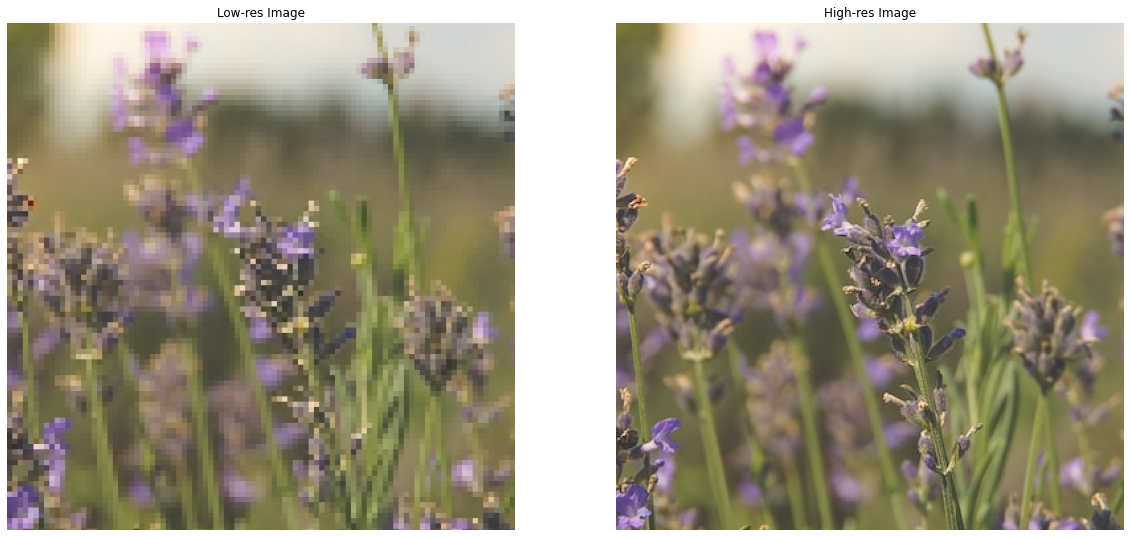

In [54]:
#display single sample image
show_tensorpair(train_dataset[15])
#train_dataset[0][2]

In [55]:
# creater dataloade for each dataset
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [56]:
# fsrcnn uses PReLU as activation function - implementhing FSRCNN(56, 12, 4) version
class FSRCNN(nn.Module):
    def __init__(self):
        super(FSRCNN, self).__init__()
        # to maintain same size image for mid part, using padding 2 : conv(5,56,1) is defined below for first part
        # but as we are using 3 channels input image we are using conv(5,56,3)
        # decreasing number of output channels to faster procedssing
        self.firstpartconv = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.prelu56 = nn.PReLU(32)
            
        # midpart shrinking - conv(1,12,56)
        self.mpsconv = nn.Conv2d(32, 12, stride=1, kernel_size=1)
        self.prelu12 = nn.PReLU(12)

        # midpart non-linear 4* conv(3,12,12) with PReLU 12 activation function 
        # changing to get faster processing to 1 *  conv(3,12,12) with PReLU 12 activation function 
        self.mpsnlmapp = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1),
            nn.PReLU(12),
        )

        # midpart expanding - conv(1,56,12)
        self.mpeconv = nn.Conv2d(12, 32, stride=1, kernel_size=1)

        # lastpart - deconv(9,3,56)
        self.deconvolution = nn.ConvTranspose2d(32, 3, kernel_size=9, stride=1, padding=4)
    
    def forward(self, x):
        # first part = feature extraction
        x = self.firstpartconv(x)
        x = self.prelu56(x)

        # mid part shrinking
        x = self.mpsconv(x)
        x = self.prelu12(x)

        #mid part non-linear mapping
        x = self.mpsnlmapp(x)

        # mid part expanding
        x = self.mpeconv(x)
        x = self.prelu56(x)

        # last part - deconvolution 
        x = self.deconvolution(x)
        return x



In [57]:
# function to calculate psnr - given by 10 * log10(R/sqrt(MSE))
def calculate_psnr(img1, img2):
    # calculate MSE loss first
    mse = nn.functional.mse_loss(img1, img2)

    # if both images are same : mse will be zero - handle it
    if mse == 0:
        return float('inf')
    # Determine the maximum pixel value
    if img1.dtype == torch.uint8:
        max_pixel = 255.0
    elif img1.dtype == torch.float32:
        max_pixel = 1.0

    #psnr calculation formula = 10 * log10(R/sqrt(MSE)) where R is maximum pizel since we are dealing in float = it is 1.0
    return 10 * math.log10(1.0 / mse.item())


In [58]:
def calculate_ssim(img1, img2):

    # initialize required value to store ssim avlues for each image
    ssim_values = []
    batch_size= img1.shape[0]
    

    # iterate over each image in the batch
    for i in range(batch_size):

        # average SSIM values across channels
        opimg = np.transpose(img1[i].cpu().numpy(), (1, 2, 0))
        ogimg = np.transpose(img2[i].cpu().numpy(), (1, 2, 0))

        ssim_val = ssim(opimg, ogimg, channel_axis=-1, data_range=ogimg.max() - ogimg.min())
        # take mean of all channels as ssim value for the image
        ssim_values.append(np.mean(ssim_val))

    # if there are any nan values then make it 0.0
    ssim_values = [0.0 if np.isnan(x) else x for x in ssim_values]

    if np.isnan(np.mean(ssim_values)):
        print(ssim_values)

    # return avrage of all images in the batch and return it as ssim value of all images in the batch
    return np.mean(ssim_values)

In [59]:
import gc
def test_model(model, test_loader, img_cnt=5):
        
    #eval mode for validation
    model.eval()
    # calculatinf peak signal to noise ratio
    psnr = 0.0
    ssim = 0.0
    count=0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_img, hr_img = lr_imgs.to(device), hr_imgs.to(device)

            # apply tained model on lores image
            outputs = model(lr_img)
            # calculate psnr and add
            psnr += calculate_psnr(outputs, hr_img)
            ssim += calculate_ssim(outputs, hr_imgs)
            if count+1 <= img_cnt:
                count+=1
                print(count)
                display_compare_images(lr_img, hr_img, outputs)
            del lr_img, hr_img, outputs
            gc.collect()

    #calculate average psnr
    psnr = psnr / len(test_loader)
    ssim = ssim / len(test_loader)
    print(f'PSNR value for testing dataset is : {psnr}')
    print(f'SSIM value for testing dataset is : {ssim}')

    return 

In [60]:
def display_compare_images(lr, hr, op):

    itr = lr.size(0)
    # compare only low res and outputted super res images
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))
    
    for i in range(2):
        lrimg = lr[i].permute(1, 2, 0).cpu().numpy()
        opimg = op[i].permute(1, 2, 0).cpu().numpy()
        
        ax[i][0].imshow(lrimg)
        ax[i][0].set_title("Low res image")
        ax[i][0].axis('off')
        ax[i][1].imshow(opimg)
        ax[i][1].set_title("Super resolved image")
        ax[i][1].axis('off')
 
    
    plt.tight_layout()
    plt.show()


In [61]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_epoch = -1
    max_psnr = 0.0
    max_ssim = 0.0
    train_loss = []
    psnr_values = []
    ssim_values = []
    max_psnr_weights = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        losssum = 0.0

        # Wrap the training loop with tqdm
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for lr_imgs, hr_imgs in train_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                
                optimizer.zero_grad()
                # Train the model 
                outputs = model(lr_imgs)
                # Calculate loss
                loss = criterion(outputs, hr_imgs)
                # Backpropagation
                loss.backward()
                optimizer.step()

                # Adding losses
                losssum += loss.item() * lr_imgs.size(0)

                # Update tqdm
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        # Calculating average loss
        tl = losssum / len(train_loader.dataset)
        
        # Evaluation mode for validation
        model.eval()
        psnr = 0.0
        ssim = 0.0
        
        with torch.no_grad():
            for lr_imgs, hr_imgs in tqdm(val_loader, desc="Validation", unit="batch"):
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                                
                outputs = model(lr_imgs)
                psnr += calculate_psnr(outputs, hr_imgs)
                ssim += calculate_ssim(outputs, hr_imgs)
        
        psnr = psnr / len(val_loader)
        ssim = ssim / len(val_loader)
        
        # Append values to lists for plotting graphs
        train_loss.append(tl)
        psnr_values.append(psnr)
        ssim_values.append(ssim)
        
        run["train/loss"].append(tl)
        run["val/psnr"].append(psnr)
        run["val/ssim"].append(ssim)
        print(f'Epoch {epoch+1}, Loss: {tl}, PSNR: {psnr}, SSIM: {ssim}')

        # Check if the PSNR and SSIM have increased than the best we had
        if psnr > max_psnr and ssim > max_ssim:
            # Save the new weights and PSNR, SSIM
            max_psnr = psnr
            max_ssim = ssim
            max_psnr_weights = copy.deepcopy(model.state_dict())
    
    print(f'Maximum PSNR: {max_psnr} and corresponding SSIM: {max_ssim}')
    # Load the max PSNR weights into the model
    model.load_state_dict(max_psnr_weights)
    return model, psnr_values, ssim_values, train_loss

In [62]:
# initializing model
model = FSRCNN().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
learning_rate=0.0003
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
params = {"learning_rate": learning_rate, "optimizer": "Adam", "Cropped image": True, "Crop specs": "Center, 384-384"}
run["parameters"] = params

In [65]:
import time
st = time.time()
# traing the model
trained_model, psnr_values, ssim_values, train_loss_values = train_model(model, train_loader, val_loader, criterion, optimizer, 100)
# printing time taken to train model
print(f'Training took {(time.time()-st)/60} min')

Validation: 100%|██████████| 282/282 [00:23<00:00, 12.19batch/s]


Epoch 1, Loss: 0.004686279531424682, PSNR: 23.955118034168777, SSIM: 0.7467864570042766


Validation: 100%|██████████| 282/282 [00:23<00:00, 12.26batch/s]


Epoch 2, Loss: 0.003931477185251369, PSNR: 25.31117158924426, SSIM: 0.7578839380690392


Validation: 100%|██████████| 282/282 [00:23<00:00, 12.26batch/s]


Epoch 3, Loss: 0.0037772741031983676, PSNR: 22.98024769940039, SSIM: 0.746612882466181


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 4, Loss: 0.003612171518311744, PSNR: 26.172197629921403, SSIM: 0.7734411490935806


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 5, Loss: 0.0035564624280408816, PSNR: 26.068745247219624, SSIM: 0.7670937192144124


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 6, Loss: 0.0035584997289077537, PSNR: 25.512735055224585, SSIM: 0.7652358894652509


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 7, Loss: 0.0035031690050241126, PSNR: 26.222731725076464, SSIM: 0.7765637107774721


Validation: 100%|██████████| 282/282 [00:23<00:00, 12.25batch/s]


Epoch 8, Loss: 0.0034879675432399446, PSNR: 26.370147408750114, SSIM: 0.7787697976785348


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 9, Loss: 0.003457136754350614, PSNR: 26.390760541485534, SSIM: 0.7832367204605265


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.28batch/s]


Epoch 10, Loss: 0.003455647552000867, PSNR: 26.158072594178385, SSIM: 0.7755864428501602


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 11, Loss: 0.003422844793463244, PSNR: 25.98178591509671, SSIM: 0.7765037824287482


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 12, Loss: 0.0034462575367099645, PSNR: 26.161549016951664, SSIM: 0.7757549189718057


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 13, Loss: 0.0034083982626357066, PSNR: 26.405308427719106, SSIM: 0.7828641142828244


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.33batch/s]


Epoch 14, Loss: 0.0034426742007701147, PSNR: 26.3643431821217, SSIM: 0.7827977185130964


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.27batch/s]


Epoch 15, Loss: 0.0033869718932723974, PSNR: 23.77369102731639, SSIM: 0.7567592047630473


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 16, Loss: 0.0034079666805632313, PSNR: 26.299445591621982, SSIM: 0.7725942300777908


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.28batch/s]


Epoch 17, Loss: 0.003351260950393406, PSNR: 26.080790591533667, SSIM: 0.7759316529788024


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 18, Loss: 0.00339017069332143, PSNR: 26.5124244545074, SSIM: 0.7843899531355987


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 19, Loss: 0.0033555811230748314, PSNR: 25.787631925994894, SSIM: 0.7715096437761969


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 20, Loss: 0.0033691782142252135, PSNR: 26.453714777532205, SSIM: 0.7830558508000476


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.31batch/s]


Epoch 21, Loss: 0.0033530614863214727, PSNR: 26.47499259929771, SSIM: 0.7838846842447916


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 22, Loss: 0.003348692815079979, PSNR: 26.511435496956494, SSIM: 0.7842496571177286


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.38batch/s]


Epoch 23, Loss: 0.0033407956094925646, PSNR: 26.389585279367928, SSIM: 0.7877586067568326


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 24, Loss: 0.003379877269953308, PSNR: 26.633390831763336, SSIM: 0.7882793089176746


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 25, Loss: 0.0033043922787758186, PSNR: 26.58592909746642, SSIM: 0.7868871875899903


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 26, Loss: 0.003326337241023265, PSNR: 26.366537066802696, SSIM: 0.7781598176939267


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 27, Loss: 0.003301139494384831, PSNR: 26.25764541212206, SSIM: 0.7830828416643413


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 28, Loss: 0.003300221213634016, PSNR: 26.602121512264247, SSIM: 0.7887043205770194


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.38batch/s]


Epoch 29, Loss: 0.003310979883510121, PSNR: 26.706081069224076, SSIM: 0.7859429319699606


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 30, Loss: 0.0032829904727276274, PSNR: 26.67421988304491, SSIM: 0.781020554773351


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 31, Loss: 0.0032836608908611065, PSNR: 26.734265829404453, SSIM: 0.7870095736802892


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 32, Loss: 0.0032394336028906357, PSNR: 25.679513671005825, SSIM: 0.7910635019025059


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 33, Loss: 0.0032588096593164947, PSNR: 26.7746610527436, SSIM: 0.7891508021675948


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.32batch/s]


Epoch 34, Loss: 0.0032363658560139908, PSNR: 26.767360798054792, SSIM: 0.7903243133150939


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 35, Loss: 0.0032331908130442837, PSNR: 26.66933876637731, SSIM: 0.7880212898161394


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.33batch/s]


Epoch 36, Loss: 0.0032158564799728865, PSNR: 26.721706640631915, SSIM: 0.7873578540822292


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.40batch/s]


Epoch 37, Loss: 0.0032159032105070332, PSNR: 26.7795904423001, SSIM: 0.7896892163136326


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 38, Loss: 0.0031941858002360606, PSNR: 26.571573837606852, SSIM: 0.7867465970364023


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.39batch/s]


Epoch 39, Loss: 0.0032214559558009235, PSNR: 26.706728127784043, SSIM: 0.7881033985961413


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.38batch/s]


Epoch 40, Loss: 0.0031855085544134115, PSNR: 26.821011002000574, SSIM: 0.7932899994841704


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 41, Loss: 0.0031895686976504706, PSNR: 26.59572095088703, SSIM: 0.792253481580856


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.38batch/s]


Epoch 42, Loss: 0.003161988529263542, PSNR: 26.673062505514892, SSIM: 0.790794773304716


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 43, Loss: 0.0031743776097625247, PSNR: 26.870800802572216, SSIM: 0.7934352295829895


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 44, Loss: 0.00314639665061136, PSNR: 26.784948080100776, SSIM: 0.7946254289742057


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.33batch/s]


Epoch 45, Loss: 0.0031594799463174252, PSNR: 26.75715572427261, SSIM: 0.7929249020121621


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 46, Loss: 0.0031510373870547695, PSNR: 26.73132338256515, SSIM: 0.7921931635826192


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 47, Loss: 0.0031358387494696115, PSNR: 26.555358173204503, SSIM: 0.789589688921651


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 48, Loss: 0.0031635532071029584, PSNR: 26.960228123169735, SSIM: 0.7937368369060205


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 49, Loss: 0.003117787519225045, PSNR: 26.686695378494484, SSIM: 0.7947879595325348


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 50, Loss: 0.003136002913192816, PSNR: 26.920900822727596, SSIM: 0.7949061563885804


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 51, Loss: 0.0031280068688044347, PSNR: 26.95373041247303, SSIM: 0.7936198292894566


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 52, Loss: 0.003111559791459309, PSNR: 26.99712434142934, SSIM: 0.7958983902601485


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.31batch/s]


Epoch 53, Loss: 0.0031097574378779287, PSNR: 26.96895907856005, SSIM: 0.7975151001984346


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.38batch/s]


Epoch 54, Loss: 0.0031042798137970243, PSNR: 27.023733193788004, SSIM: 0.7981899811866435


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 55, Loss: 0.003113754882965434, PSNR: 26.9896376134367, SSIM: 0.797487698019819


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 56, Loss: 0.003113439732619542, PSNR: 26.934616359009773, SSIM: 0.7968309047162956


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.28batch/s]


Epoch 57, Loss: 0.0030948075960717056, PSNR: 27.021699563142377, SSIM: 0.7948482780591816


Validation: 100%|██████████| 282/282 [00:23<00:00, 12.24batch/s]


Epoch 58, Loss: 0.0031016380686622056, PSNR: 26.993946348359607, SSIM: 0.7988624815822493


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 59, Loss: 0.0030959020946907485, PSNR: 26.681581689874065, SSIM: 0.7845441502459506


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 60, Loss: 0.0030838750094339417, PSNR: 26.98440665612851, SSIM: 0.7950894549383339


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 61, Loss: 0.003085424698726062, PSNR: 26.754239430343418, SSIM: 0.7922181374003702


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.32batch/s]


Epoch 62, Loss: 0.0030850369247273717, PSNR: 26.98954448164061, SSIM: 0.7961706874218393


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 63, Loss: 0.003088310262645775, PSNR: 26.747605362654102, SSIM: 0.7964130054551659


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.32batch/s]


Epoch 64, Loss: 0.0030865011432763137, PSNR: 26.94501827903694, SSIM: 0.7948417311653178


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.33batch/s]


Epoch 65, Loss: 0.0030921695612400393, PSNR: 27.04432582483395, SSIM: 0.7987493965642672


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.28batch/s]


Epoch 66, Loss: 0.0030720186433391863, PSNR: 27.072444267441636, SSIM: 0.7994511031301309


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 67, Loss: 0.0030800922612684925, PSNR: 27.001032959964093, SSIM: 0.7971464908080743


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.31batch/s]


Epoch 68, Loss: 0.0030720703323196224, PSNR: 27.027646907892006, SSIM: 0.7994643840806704


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.28batch/s]


Epoch 69, Loss: 0.003082062940134823, PSNR: 27.07176487829273, SSIM: 0.797386534776248


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.32batch/s]


Epoch 70, Loss: 0.0030785078529995467, PSNR: 26.976089929259487, SSIM: 0.7982364563231773


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.30batch/s]


Epoch 71, Loss: 0.0030773126832471936, PSNR: 27.06323071391377, SSIM: 0.7980063943364096


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.31batch/s]


Epoch 72, Loss: 0.003072143051219624, PSNR: 27.098992503628878, SSIM: 0.8003947633378049


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.29batch/s]


Epoch 73, Loss: 0.0030751089288029976, PSNR: 27.08872256546734, SSIM: 0.8009803299362778


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.28batch/s]


Epoch 74, Loss: 0.0030619889139972176, PSNR: 27.069150380885397, SSIM: 0.800469308985886


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.27batch/s]


Epoch 75, Loss: 0.0030540754154253437, PSNR: 27.05880625178899, SSIM: 0.7980127142253497


Validation: 100%|██████████| 282/282 [00:23<00:00, 12.26batch/s]


Epoch 76, Loss: 0.003062691697151469, PSNR: 27.11983409303748, SSIM: 0.8014730382050183


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.33batch/s]


Epoch 77, Loss: 0.003060134212933604, PSNR: 26.87091224954866, SSIM: 0.7959755324091472


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 78, Loss: 0.0030478511115379046, PSNR: 27.028630683434713, SSIM: 0.7995311466726005


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.32batch/s]


Epoch 79, Loss: 0.0030524361074061256, PSNR: 27.065330828984248, SSIM: 0.7979150798092497


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.41batch/s]


Epoch 80, Loss: 0.003051538431432217, PSNR: 27.092395334493926, SSIM: 0.7992704820337025


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 81, Loss: 0.00305435003196266, PSNR: 27.091895935213767, SSIM: 0.7988046390790466


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.40batch/s]


Epoch 82, Loss: 0.0030484670548834606, PSNR: 26.944540020924443, SSIM: 0.7883184565931347


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.38batch/s]


Epoch 83, Loss: 0.003050237536676896, PSNR: 27.11203155170772, SSIM: 0.7979358129256161


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.40batch/s]


Epoch 84, Loss: 0.0030472468808454283, PSNR: 27.091838331463805, SSIM: 0.7957961821387


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.39batch/s]


Epoch 85, Loss: 0.0030591484467474245, PSNR: 27.07012374360948, SSIM: 0.7970257370818591


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.42batch/s]


Epoch 86, Loss: 0.0030454220544354556, PSNR: 27.11154878853335, SSIM: 0.7988734014913546


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.40batch/s]


Epoch 87, Loss: 0.003050380826103264, PSNR: 27.13604878640022, SSIM: 0.7989185111108401


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.40batch/s]


Epoch 88, Loss: 0.0030378022193518948, PSNR: 27.03786759174516, SSIM: 0.7996987107586353


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 89, Loss: 0.0030359083719437513, PSNR: 27.15169391188799, SSIM: 0.801399236135449


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]


Epoch 90, Loss: 0.00303683507966833, PSNR: 27.142840583131548, SSIM: 0.800798347233035


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.32batch/s]


Epoch 91, Loss: 0.0030372811172350873, PSNR: 26.780415734540977, SSIM: 0.7955043863320181


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.40batch/s]


Epoch 92, Loss: 0.003045115365264196, PSNR: 27.16581526749686, SSIM: 0.8015642017126083


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 93, Loss: 0.003034223904000345, PSNR: 27.148523083738805, SSIM: 0.7992251291342661


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 94, Loss: 0.0030309400459777973, PSNR: 27.107911381449572, SSIM: 0.7980315482362788


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.39batch/s]


Epoch 95, Loss: 0.0030422208465529133, PSNR: 27.136123154599165, SSIM: 0.8011675510846131


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.35batch/s]


Epoch 96, Loss: 0.0030201645363924375, PSNR: 27.14184769986135, SSIM: 0.7992864638989698


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.30batch/s]


Epoch 97, Loss: 0.003031154102083634, PSNR: 27.025117808916445, SSIM: 0.7948107940296755


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.36batch/s]


Epoch 98, Loss: 0.0030324856495281814, PSNR: 27.160978963300163, SSIM: 0.8019392294875274


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.37batch/s]


Epoch 99, Loss: 0.0030308058825615075, PSNR: 27.157878377017415, SSIM: 0.8024753040455758


Validation: 100%|██████████| 282/282 [00:22<00:00, 12.34batch/s]

Epoch 100, Loss: 0.0030343213518837413, PSNR: 27.046927464802828, SSIM: 0.7971061301146839
Maximum PSNR: 27.16581526749686 and corresponding SSIM: 0.8015642017126083
Training took 131.1834915439288 min


In [66]:
# save the max psnr  model weights
pthname = "max_pcnr_fsrcnn"+str(time.time())+".pth"
torch.save(trained_model.state_dict(), pthname)

# add this to neptuneai log
model_det = {"name": pthname, "statedict / whole model": "statedict", "epochs": 100}

run["checkpoint"] = model_det

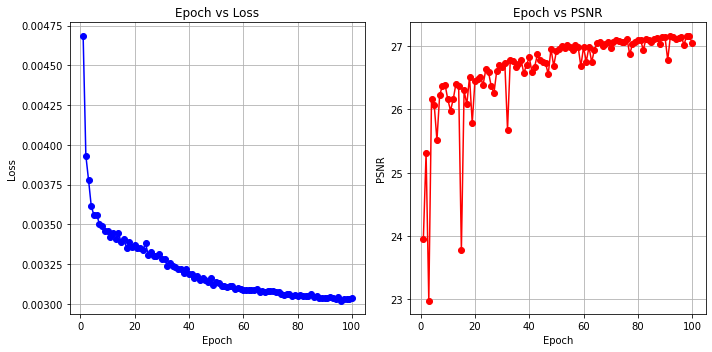

In [67]:
num_epochs=100
# Plot epoch vs loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o', color='b')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot epoch vs PSNR
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), psnr_values, marker='o', color='r')
plt.title('Epoch vs PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.grid(True)

plt.tight_layout()
plt.show()

In [68]:
trained_model_loaded = FSRCNN().to(device)
trained_model_loaded.load_state_dict(torch.load(pthname))


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


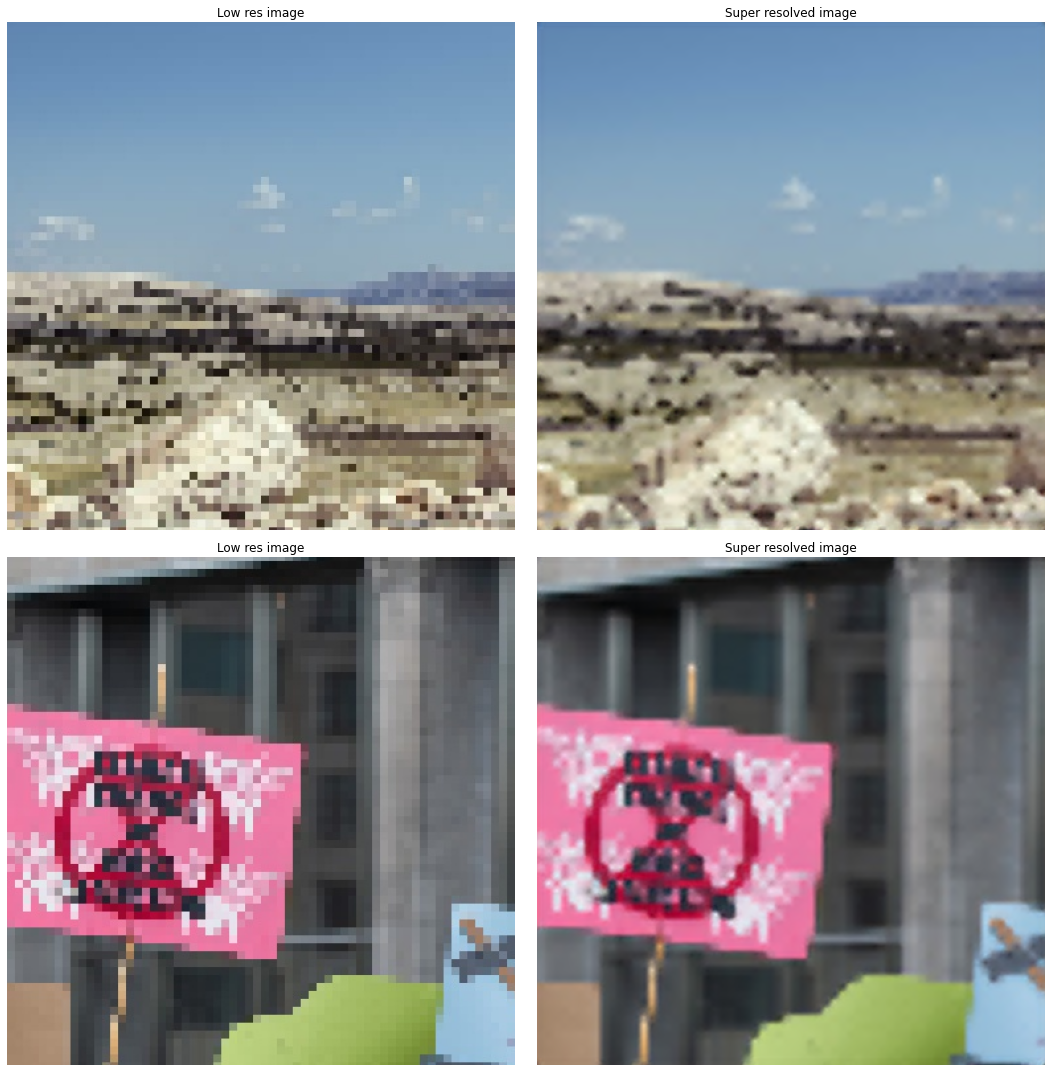

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


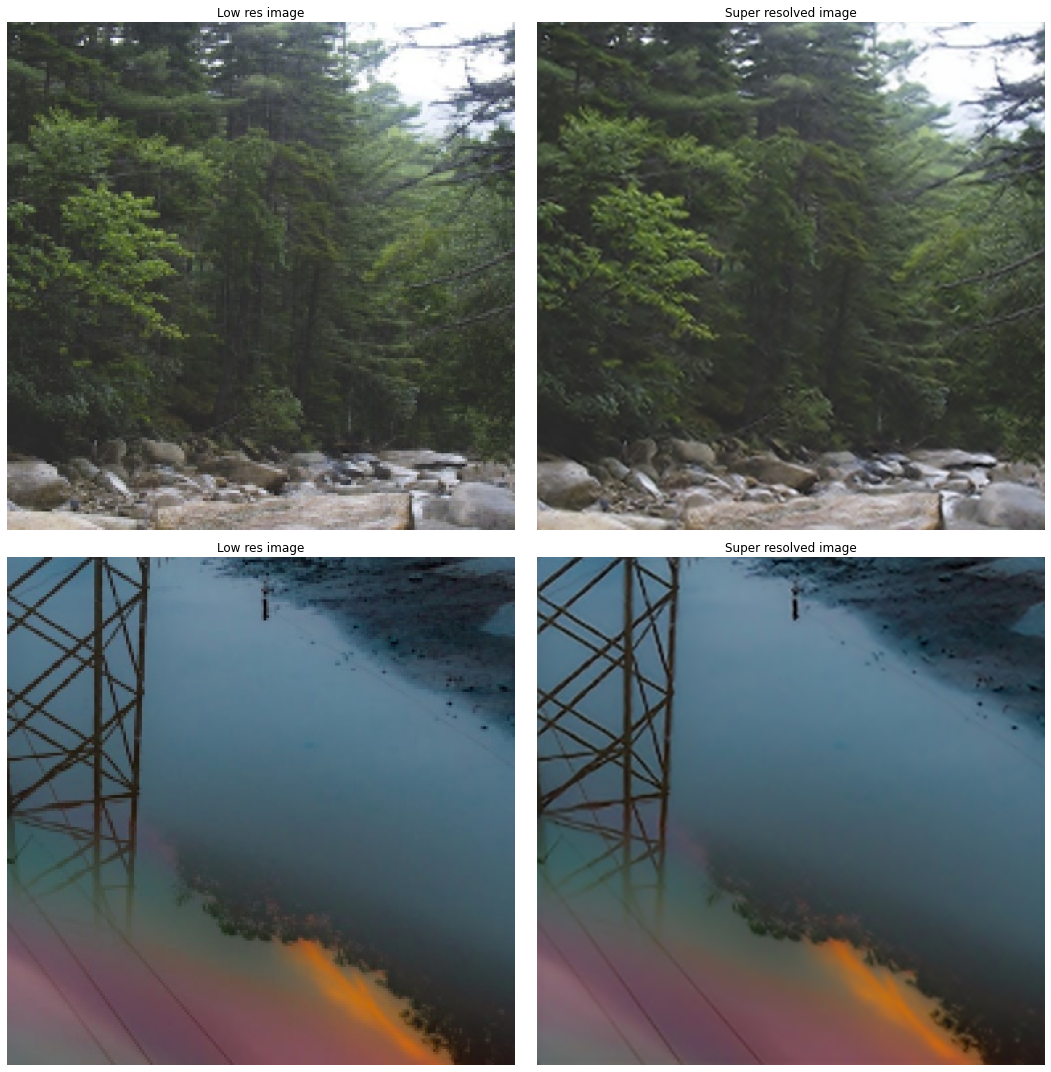

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


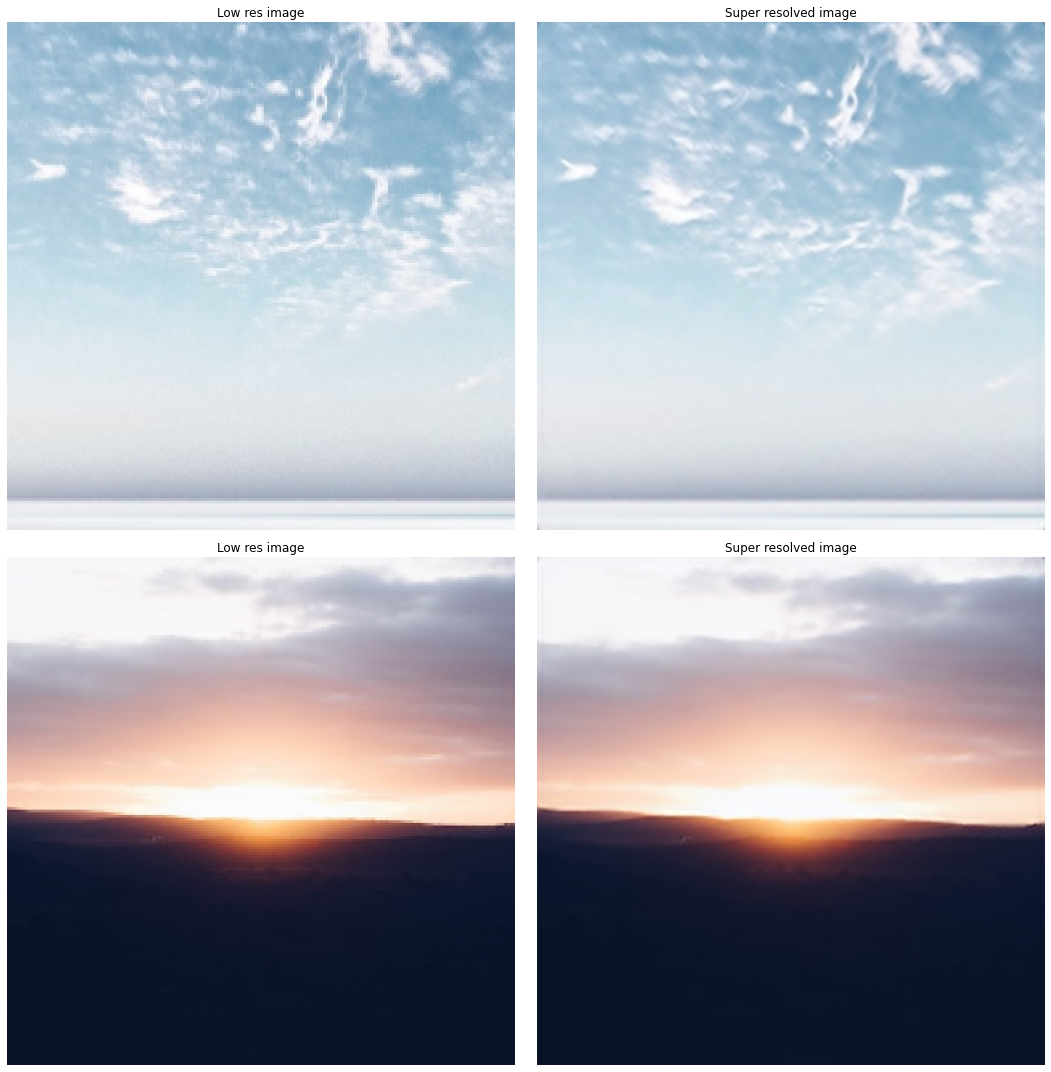

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


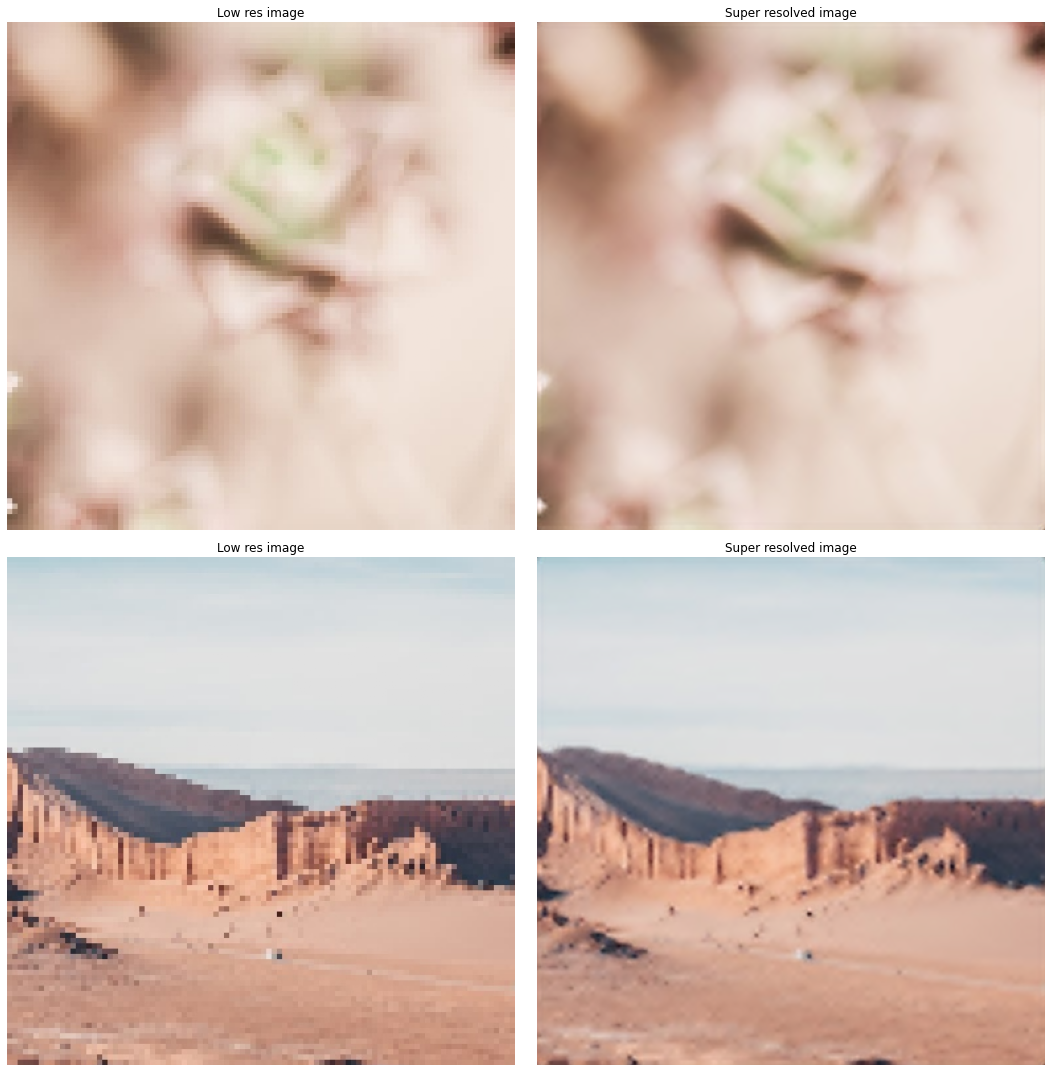

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


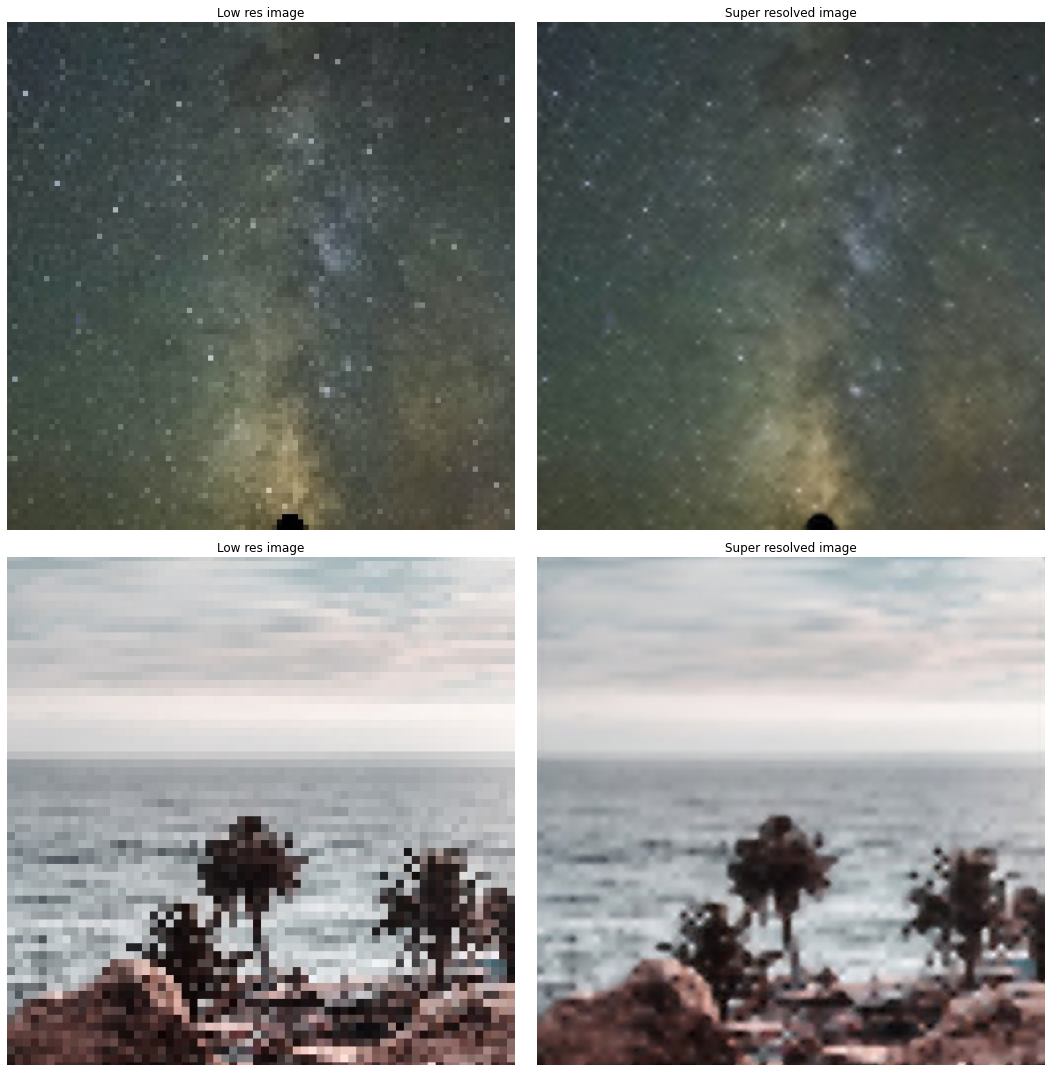

PSNR value for testing dataset is : 27.2032200891061
SSIM value for testing dataset is : 0.8041316488816965


In [69]:
test_model(trained_model_loaded, test_loader)

In [25]:
#https://towardsdatascience.com/review-fsrcnn-super-resolution-80ca2ee14da4#:~:text=From%20SRCNN%20to%20FSRCNN,which%2043.5%20fps%20is%20obtained.

In [70]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/ImgResProject/ImageRes/e/FSRCNN-18/metadata
